[View in Colaboratory](https://colab.research.google.com/github/gresash/ML4AAD-Lab-SS2018/blob/master/Exercise_1_1.ipynb)

# Exercise 1.1

* Plotting of how SMAC performed over time 

## Installation of SMAC and its Dependencies

In [34]:
!apt-get install swig -y
!pip install Cython
!pip install pyrfr==0.8.0 --no-cache --user
# hack to find pyrfr
import sys
sys.path.insert(0, "./.local/lib/python3.6/site-packages")

!pip install git+https://github.com/automl/SMAC3.git@development


Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.10-1.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Cloning https://github.com/automl/SMAC3.git (to revision development) to /tmp/pip-req-build-quwj1ly1
  Running setup.py bdist_wheel for smac ... - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ex7rneof/wheels/f4/8d/4f/2ba4cb80693f139ea06c2e8541e012a93738fb56bc1e43a202
Successfully built smac


## Define Function to be optimized

In [0]:
import math
import numpy as np


def test_func(x):
    # x is vector; here of length 1
    x = x[0]
    return math.cos(x) * x ** 2 + x


## Plot Function

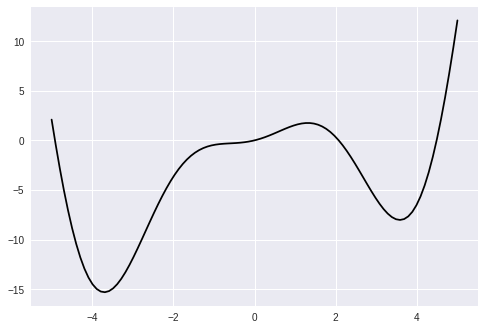

In [36]:
#plot the function values for 100 input values ranging from -5 to 5 
import matplotlib.pyplot as plt

x_points = np.linspace(start=-5, stop=5, num=100)
y_points = list(map(test_func, map(lambda x: [x], x_points)))

plt.plot(x_points, y_points, 'k')


## Optimize with SMAC

In [37]:
from smac.facade.func_facade import fmin_smac

MAX_FUN = 10

x, cost, smac = fmin_smac(func=test_func,
                          x0=[-0],  # default values
                          bounds=[(-5, 5)],  # bounds of each x
                          maxfun=MAX_FUN,  # maximal number of function evaluations
                          rng=12568)  # random seed

print("Best x: %f" % (x[0]))
print("Best y: %f" % (cost))


Best x: -3.282592
Best y: -13.951069


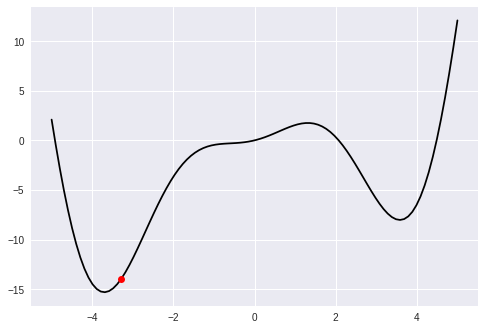

In [38]:
plt.plot(x_points, y_points, 'k', x, [cost], 'ro')

## How has SMAC performed over time?

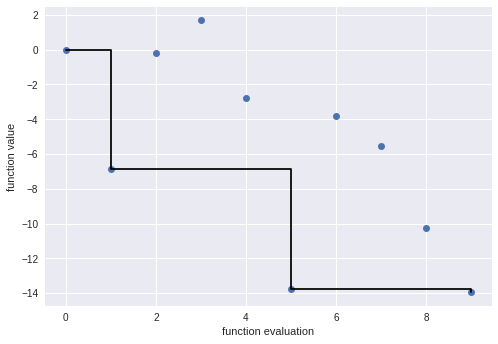

In [39]:
import numpy as np
# get runhistory, all runs ever evaluated by smac
runhistory = smac.get_runhistory()

# extract x value and corresponding y value
x_smac = []
y_smac = []
for entry in runhistory.data:  # iterate over data because it is an OrderedDict
    config_id = entry.config_id  # look up config id
    config = runhistory.ids_config[config_id]  # look up config
    y_ = runhistory.get_cost(config)  # get cost
    x_ = config["x1"]  # there is only one entry in our example
    x_smac.append(x_)
    y_smac.append(y_)
x_smac = np.array(x_smac)
y_smac = np.array(y_smac)


# Plotting
plt.plot(y_smac, 'o')
plt.xlabel('function evaluation')
plt.ylabel('function value')

# let's plot only the best function value at each time step
y_best = np.zeros(MAX_FUN)
for id in range(MAX_FUN):
    y_best[id] = np.min(y_smac[:id+1])

plt.step(y_best, 'k', where="post")  # please note that we use step function!


## Visualizing the Acquisition Function (Expected Improvement)

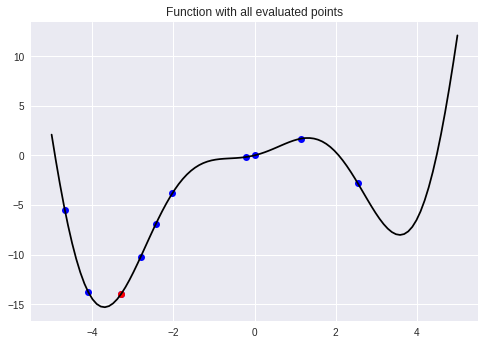

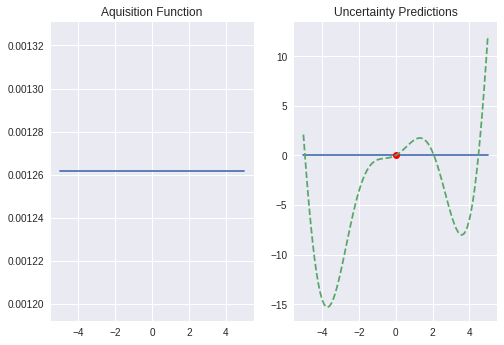

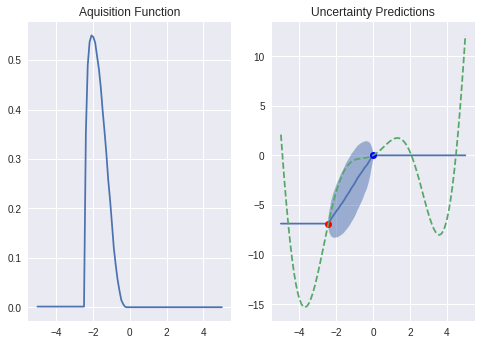

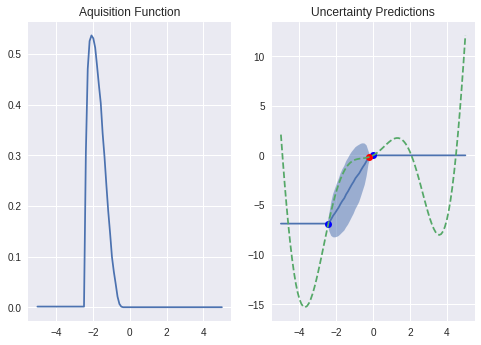

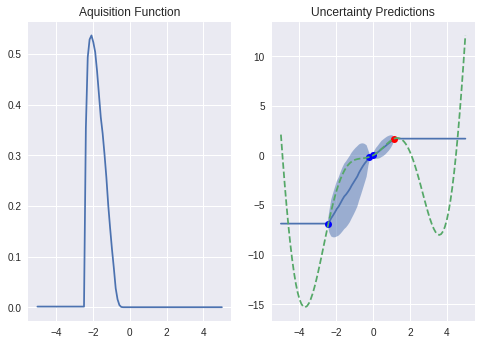

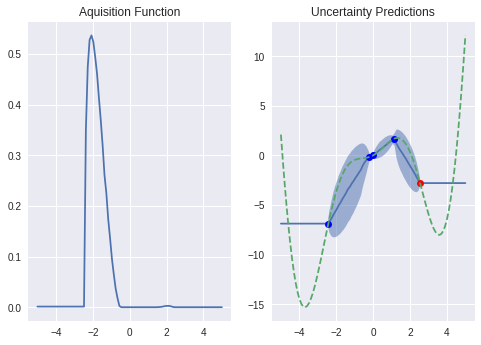

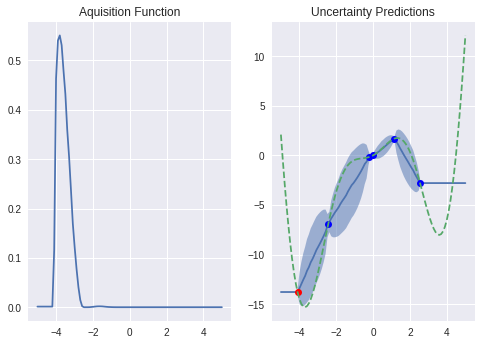

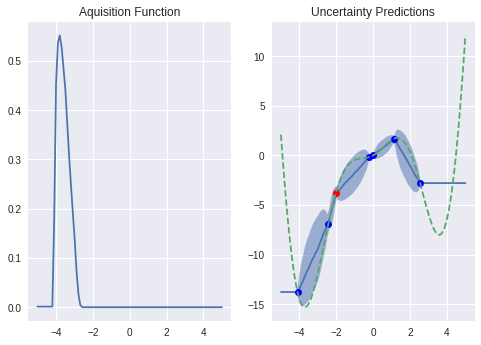

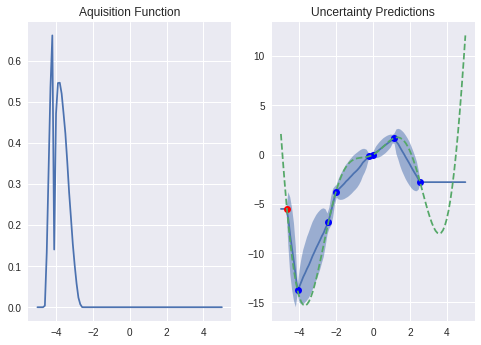

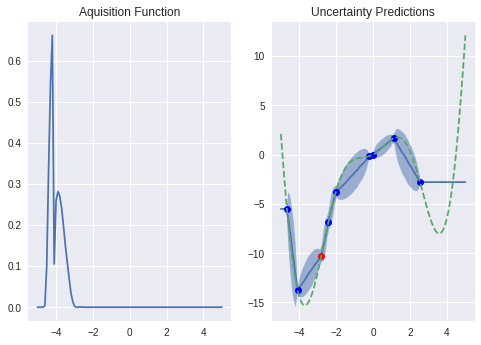

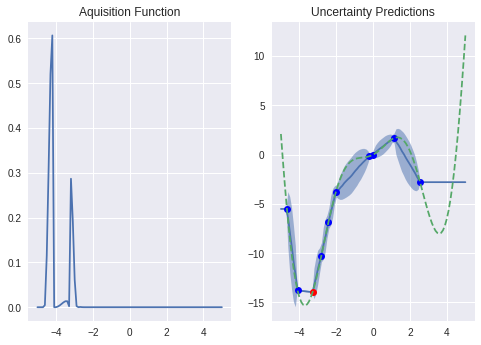

In [40]:
from smac.optimizer.acquisition import EI
from smac.epm.rf_with_instances import RandomForestWithInstances

# Plot all evaluated points on the function
ax = plt.plot(x_smac, y_smac, 'bo', x[0], cost, 'ro', x_points, y_points, 'k')
plt.title("Function with all evaluated points")


def plot_state(smac, model, x_smac1, y_smac1):
    '''
    plot function with all evaluated points,
    EI acquisition function
    Predictions with uncertainties
    '''
    # cost all points for x
    x_smac_ = np.array([[x] for x in x_smac1])
    y_smac_ = np.array([[y] for y in y_smac1])
    # as an alternative, we could extract the points from the runhistory again
    # but these points will be scaled to a unit-hypercube
    # X, Y = smac.solver.rh2EPM.transform(runhistory)

    model.train(x_smac_, y_smac_)

    acq_func = EI(model=model)
    acq_func.update(model=model, eta=np.min(y_smac1))

    x_points_ = np.array([[x] for x in x_points])
    acq_values = acq_func._compute(X=x_points_)[:, 0]

    # plot acquisition function
    y_mean, y_var = model.predict(x_points_)
    y_mean = y_mean[:, 0]
    y_std = np.sqrt(y_var)[:, 0]

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(1, 2, 1)
    ax1.plot(x_points, acq_values)
    plt.title("Aquisition Function")

    # plot uncertainties
    ax1 = fig1.add_subplot(1, 2, 2)
    ax1.plot(x_points, y_mean)
    ax1.fill_between(x_points, y_mean-y_std, y_mean+y_std, alpha=0.5)
    ax1.plot(x_smac1[:-1], y_smac1[:-1], 'bo')
    ax1.plot(x_smac1[-1], y_smac1[-1], 'ro')
    ax1.plot(x_points, y_points, '--')
    plt.title("Uncertainty Predictions")

    # set up a EPM (empirical performance model)
    types, bounds = np.array([0]), np.array([[0.0, 1.0]])
    
    model = RandomForestWithInstances(types=types,
                                      bounds=bounds,
                                      instance_features=None,
                                      seed=12345,
                                      pca_components=12345,
                                      ratio_features=1,
                                      num_trees=1000,
                                      min_samples_split=1,
                                      min_samples_leaf=1,
                                      max_depth=100000,
                                      do_bootstrapping=False,
                                      n_points_per_tree=-1,
                                      eps_purity=0)
for i in range(MAX_FUN):
    plot_state(smac, model, x_smac[:(i+1)], y_smac[:(i+1)])
